# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to instead using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents) according to all patterns of covariation among their features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
import ct

In [ ]:
ct.data_dir

In [ ]:
import nltk

In [ ]:
nltk.data.path

In [4]:
import os
import sklearn

In [7]:
test = sklearn.datasets.fetch_20newsgroups(data_home = '../data/scikit_learn_data')

In [8]:
test = sklearn.datasets.fetch_20newsgroups()

In [1]:
#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.feature_extraction.text
import sklearn.decomposition
from sklearn import preprocessing, linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups, make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer  #Feature extraction
from sklearn.naive_bayes import MultinomialNB #Our learner.
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors

import nltk #For tokenizing and normalizing
nltk.data.path.append('../data/nltk_data')
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
from matplotlib.colors import ListedColormap
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

%matplotlib inline

import ct as ai #Our library where all the messy magic lies

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

/Users/Reid/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We also develop a couple of functions for splitting and normalizing our text data:

In [2]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
        
    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))
    
    return list(workingIter)

stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

In [3]:
def count_words(traingDF, textColumn, trainingColumn):
    counts = collections.defaultdict(lambda: [0, 0])
    for index, row in traingDF.iterrows():
        for word in set(row[textColumn]):
            if row[trainingColumn]:
                counts[word][0] += 1
            else:
                counts[word][1] += 1
    return counts

In [4]:
def split_data(data, prob):
    """split data into fractions [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

# Cartoon Examples

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise or randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [5]:
noise = .2

#dfTrain, dfTest = ai.trainTestSplit(ai.random())
#dfTrain, dfTest = ai.trainTestSplit(ai.andSplit(noise))
#dfTrain, dfTest = ai.trainTestSplit(ai.xorSplit(noise))
dfTrain, dfTest = ai.trainTestSplit(ai.targetSplit(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

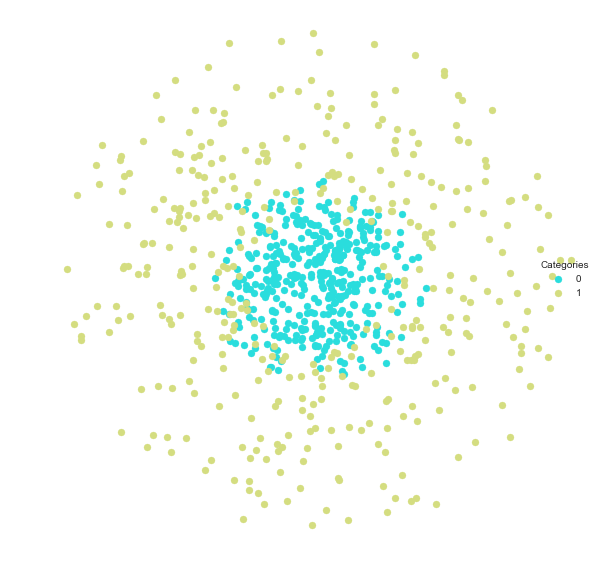

In [6]:
ai.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [7]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [8]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Algorithm evaluation

We can look at few measurements of it's performance, by using the testing set

In [9]:
ai.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.892021,0.919034,0.105,0.918605,0.849462
1,0.892021,0.923386,0.105,0.877193,0.934579


This lets us look at which classes do better

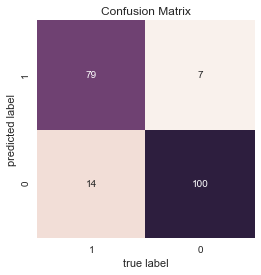

In [10]:
ai.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better

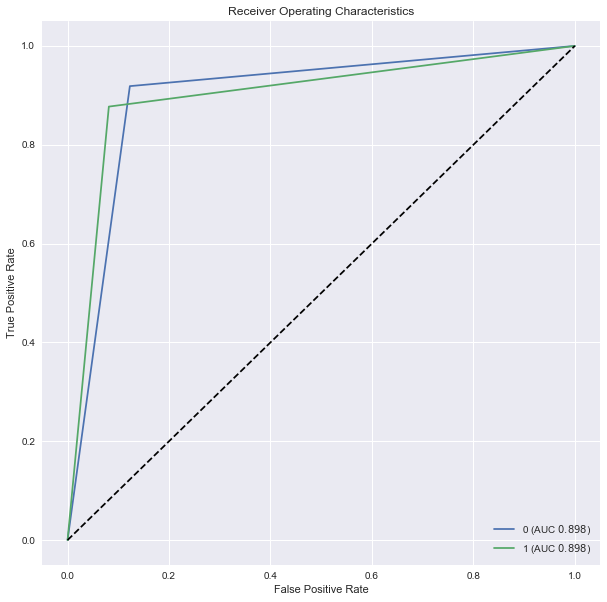

In [11]:
ai.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other.

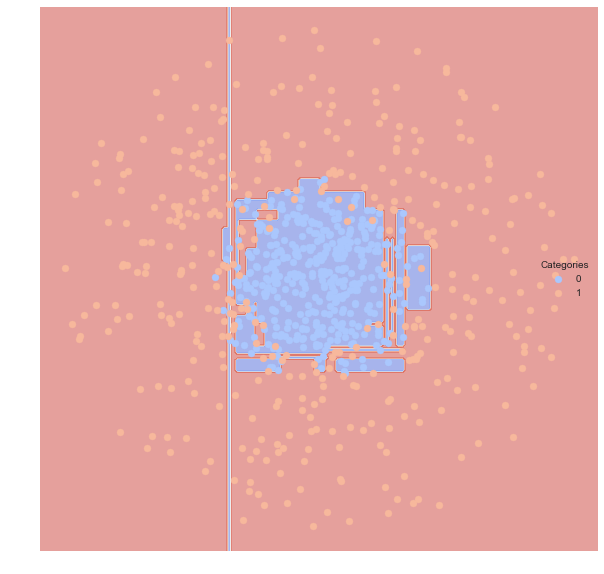

In [12]:
ai.plotregions(dfTrain, clf)

## Now we do the same for real data

Optional data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator
+ emails classified as Spam or Ham

In [13]:
dfTrain, dfTest = ai.trainTestSplit(ai.loadReddit())
#dfTrain, dfTest = ai.trainTestSplit(ai.loadNewsGroups())
#dfTrain, dfTest = ai.trainTestSplit(ai.loadSenateLarge())
#dfTrain, dfTest = ai.trainTestSplit(ai.loadSpam())

Loading Reddit data
Converting to vectors


In [14]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [15]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None)

In [16]:
ai.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Weeaboo Tales,0.789168,0.852142,0.175549,0.939759,0.604651
Relationships,0.822033,0.655097,0.156740,0.487179,0.791667
Tales From Tech Support,0.930501,0.866062,0.065831,0.792208,0.924242
Bad Roommates,0.808344,0.734264,0.147335,0.679012,0.723684


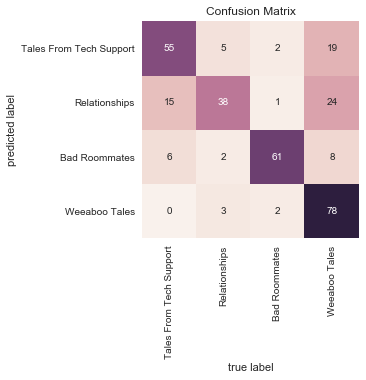

In [17]:
ai.plotConfusionMatrix(clf, dfTest)

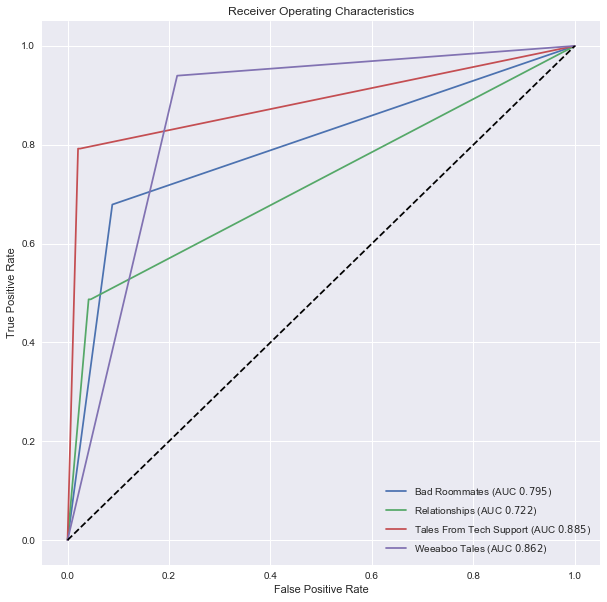

In [18]:
ai.plotMultiROC(clf, dfTest)

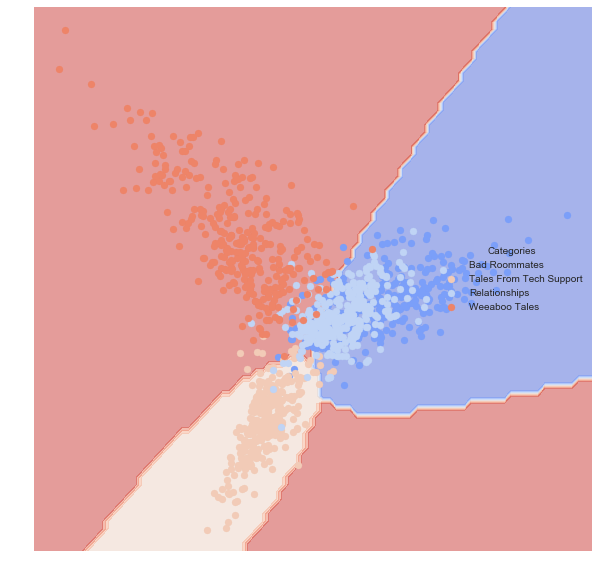

In [19]:
ai.plotregions(dfTrain, clf)

# Clinton / Obama Press Releases

We Often will not have this nicely prepared data, so we will work though the proccess in more detail here:

While the Clinton and Obama Senatorial Press are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [ ]:
ObamaClintonReleases = pandas.read_csv("../data/ObamaClintonReleases.csv")
ObamaClintonReleases = ObamaClintonReleases.dropna(axis=0, how='any')
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

Let's turn the 'targetSenator' column into a binary variable.

In [ ]:
ObamaClintonReleases['IsObama'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Let's split the data into training data and test data.

In [ ]:
np.random.seed(0)
ObamaClintonReleases = ObamaClintonReleases.reindex(np.random.permutation(ObamaClintonReleases.index))
holdBackFraction = .25
holdBackIndex = int(holdBackFraction * len(ObamaClintonReleases))
train_data = ObamaClintonReleases[holdBackIndex:].copy()
test_data = ObamaClintonReleases[:holdBackIndex].copy()

In [ ]:
print (len(train_data))
print (len(test_data))

## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix:

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization but rather classification and so all principal components are calculated.

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA().fit(TFVects.toarray())
reduced_data = pca.transform(TFVects.toarray())

Visualization in 2D:

In [ ]:
colordict = {
True: 'red',
False: 'blue',
    }
colors = [colordict[c] for c in train_data['IsObama']]
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Clinton from Obama very well. Let's perform a screeplot to see how many dimensions we need.

In [ ]:
n = TFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
X = reduced_data[:, :10]

Transform our predictor variable. 

In [ ]:
Y = np.array([int(label) for label in train_data['IsObama']])

Now we fit a logistic regression to our data.

In [ ]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

Let's see how the logistic regression performs on the training dataset on we develop the model. Unfortunately, mean accuracy is only about 68%.

In [ ]:
logistic.score(X,Y)

How does it perform on the testing dataset, which we "held out" and did not use for model training?

In [ ]:
TFVects_test = TFVectorizer.transform(test_data['text'])
reduced_data_test = pca.transform(TFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in test_data['IsObama']])
logistic.score(X_test, Y_test)

Slightly poorer. How about using more dimensions (40)?

In [ ]:
X = reduced_data[:, :40]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :40]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

Or still more (100)?

In [ ]:
X = reduced_data[:, :100]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :100]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

Or even more (200)!

In [ ]:
X = reduced_data[:, :200]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :200]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

This is becoming ridiculous (400)!

In [ ]:
X = reduced_data[:, :400]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :400]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 80%. We can, however, try a logistic regression that uses L1 regularization or the L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
X = TFVects
logistic_l1= linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(X, Y)
print(logistic_l1.score(X,Y))

Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(TFVects_test,Y_test))

84% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes.

In [ ]:
#wc = wordCounts(train_data, 'normalized_text')
wc = count_words(train_data, 'normalized_text', 'IsObama')
wc['veteran']

In [ ]:
def word_probabilities(counts, total_spams, total_non_spams, k=0.5):
    """turn the word_counts into a list of triplets 
    w, p(w | spam) and p(w | ~spam)"""
    retTuples = []
    for w, (spam, non_spam) in counts.items():
        retTuples.append((w,
             (spam + k) / (total_spams + 2 * k),
             (non_spam + k) / (total_non_spams + 2 * k)))
    return retTuples


def spam_probability(word_probs, message_words):
    #message_words = tokenize(message)
    log_prob_if_spam = log_prob_if_not_spam = 0.0 #Initialize; we are working with log probs to deal with underflow.

    for word, prob_if_spam, prob_if_not_spam in word_probs: #We iterate over all possible words we've observed
        # for each word in the message, 
        # add the log probability of seeing it 
        if word in message_words:
            log_prob_if_spam += math.log(prob_if_spam) #This is prob of seeing word if spam
            log_prob_if_not_spam += math.log(prob_if_not_spam) #This is prob of seeing word if not spam

        # for each word that's not in the message
        # add the log probability of _not_ seeing it
        else:
            log_prob_if_spam += math.log(1.0 - prob_if_spam)
            log_prob_if_not_spam += math.log(1.0 - prob_if_not_spam)
    P = 1/(1 + math.exp(log_prob_if_not_spam - log_prob_if_spam))
    #prob_if_spam = math.exp(log_prob_if_spam) #Compute numerator
    #prob_if_not_spam = math.exp(log_prob_if_not_spam)
    #return prob_if_spam / (prob_if_spam + prob_if_not_spam) #Compute whole thing and return
    return P

class NaiveBayesClassifier:

    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set, trainingColumn, textColumn): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = training_set[trainingColumn].value_counts()[True]
        num_non_spams = len(training_set) - num_spams
        
        # run training data through our "pipeline"
        word_counts = count_words(training_set, textColumn, trainingColumn)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message

In [ ]:
classifier = NaiveBayesClassifier()
classifier.train(train_data, 'IsObama', 'normalized_text')

Let's evaluate the result on the test data.

In [ ]:
classified = []
for index, row in test_data.iterrows():
    classified.append((row['normalized_text'], row['IsObama'], classifier.classify(row['normalized_text'])))

# assume that spam_probability > 0.5 corresponds to spam prediction # and count the combinations of (actual is_spam, predicted is_spam)
counts = collections.Counter((actual, predicted_probability > 0.5)
                     for text, actual, predicted_probability in classified)

counts

Precision:

In [ ]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
print(precision)

Recall:

In [ ]:
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
print(recall)

F-measure:

In [ ]:
f_measure = 2 * (precision * recall)/(precision + recall)
print (f_measure)

In [ ]:
df_classification = pandas.DataFrame(classified, columns = ['press release', 'is Obama', 'posterior probability'])
df_classification = df_classification.round(2)

Let's take a look at how well our posterior distribution looks relative to the truth.

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(False)
ax1.set_frame_on(False)
df_classification[df_classification['is Obama'] == True]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Obama', color = 'red')
df_classification[df_classification['is Obama'] == False]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Clinton', color = 'blue')
ax1.set_xlim((0,1.1))
ax1.legend()
ax1.set_xlabel('posterior')
ax1.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate.

In [ ]:
def p_obama_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_obama, prob_if_not_obama = word_prob
    return prob_if_obama / (prob_if_obama + prob_if_not_obama)

In [ ]:
words = sorted(classifier.word_probs,key=p_obama_given_word)

In [ ]:
Obama_words = words[-15:]
Clinton_words = words[:15]

What are the words that distinguish Obama and Clinton press releases?

In [ ]:
Obama_words

In [ ]:
Clinton_words

## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [ ]:
data = fetch_20newsgroups(data_home = '../data/scikit_learn_data') #Free data to play with: documents from a newsgroup corpus.
data.target_names #Possible categories, i.e., the newsgroups

This dataset has a built in breakdown into training and testing sets. We can pick specific categories, and pull the relevant training and testing sets. 

In [ ]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories, data_home = '../data/scikit_learn_data')
test = fetch_20newsgroups(subset='test', categories=categories, data_home = '../data/scikit_learn_data')

In [ ]:
train['target']

In [ ]:
len(train.data) #See how many training examples

In [ ]:
len(test.data) #Ditto for testing -- it's about 60% training, 40% testing

In [ ]:
print(train.data[5]) #Look at an example
#print(train.target_names[5])

We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document but rarely across documents in the corpus (more distinctive). 

We also take advantage of a useful feature of Scikit-Learn: we can make pipelines...

In [ ]:
model = make_pipeline(TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2'), MultinomialNB()) #This applies the vectorizer, then trains Multinomial NB

In [ ]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

In [ ]:
labels = model.predict(test.data)

In [ ]:
labels.size

We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding.

In [ ]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's calculate the precision, recall, and F-measures.

In [ ]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

Get the ROC curves.
First, we need to binarize the labels.

In [ ]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform([1, 3]))

In [ ]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [ ]:
n_classes = 4

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

In [ ]:
lw = 2
n_classes = 4
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'olive']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and use the predict method to see if it can assign it to a category. Using our model to extend to new, uncoded data might be the primary purpose of a social science application.

In [ ]:
def predict_category(s, train=train, model=model): #We just define a simple function here
    return train.target_names[model.predict([s])]

In [ ]:
#predict_category('rockets')

Try it yourself with your own strings!


## Now let's add Bernie Sanders to our Obama / Clinton face-off

In [ ]:
ObamaClintonSandersReleases = pandas.read_csv("../data/ObamaClintonSandersReleases.csv")
ObamaClintonSandersReleases = ObamaClintonSandersReleases.dropna(axis=0, how='any')

Let's split the data into training data and test data.

In [ ]:
data = list(zip(ObamaClintonSandersReleases['text'], ObamaClintonSandersReleases['targetSenator']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

In [ ]:
print (len(train_data))
print (len(test_data))

In [ ]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [ ]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

In [ ]:
labels = model.predict(test.data)

In [ ]:
labels.size

In [ ]:
model.classes_

Confusion matrix:

In [ ]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's get the precision, recall, and F-measure.

In [ ]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

In order to get the ROC curves, first we need to binarize the labels.

In [ ]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform(['Clinton', 'Obama']))

In [ ]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [ ]:
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

In [ ]:
n_classes = 3
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and use the predict method assign it to a category. This extrapolation to new, untagged data will likely be the main point of a social science application.

In [ ]:
model.predict(['money'])

In [ ]:
model.predict(['Wall Street'])

In [ ]:
model.predict(['Chicago'])

# Decision Trees

We now return to the python Machine learning package, Scikit-Learn, for a decision tree example. Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

To illustrate how these work, we first create some artificial data to learn:

In [ ]:
X, y = make_blobs(n_samples=300, centers=4,
                random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X,y)

To see what's going on visually with the classification, we can use this (complex) visualizer. 

In [ ]:
def visualize_classifier(model, X, y, Xmod, ymod, ax=None, cmap='rainbow'): #X and y are plotted; Xmod and ymod train
    ax = ax or plt.gca()
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(Xmod, ymod)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

In [ ]:
Xnew, ynew = make_blobs(n_samples=1000, centers=4,
                random_state=0, cluster_std=1.0)

In [ ]:
visualize_classifier(DecisionTreeClassifier(max_depth=4,random_state=0), Xnew, ynew, X, y) #We train on the full data

In [ ]:
accuracy_score(ynew,DecisionTreeClassifier(max_depth=10,random_state=0).fit(X,y).predict(Xnew))

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X,y)
    score = accuracy_score(ynew,tree2.predict(Xnew))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)

We an select different layers of the tree or "prune" the decision tree. At approximately four layers down the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5,random_state=1) #test_size means a 50/50 split
print(len(X))
print(len(Xtrain))
print(len(Xtest))

With some abuse of notation, we can use the visualizer to plot first a classifier trained on the "training" half of the data.

In [ ]:
visualize_classifier(DecisionTreeClassifier(max_depth=5,random_state=0), X, y, Xtrain, ytrain) #Train with half the data

Now we can train on the second half of the data--allegedly the test data--to see how different training sets affect the decision boundaries.

In [ ]:
visualize_classifier(DecisionTreeClassifier(random_state=0), X, y, Xtest, ytest) #Train with other half of the data

Finally, we can get a sense of the performance by training on the training data, but PLOTTING the test data

In [ ]:
visualize_classifier(DecisionTreeClassifier(), Xtest, ytest, Xtrain, ytrain) #Trains with train data, plots test data

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
#?BaggingClassifier #Learn more

In [ ]:
bag.fit(X,y) #Fit the bagged classifier

In [ ]:
Xnew, ynew = make_blobs(n_samples=10000, centers=4,
                random_state=0, cluster_std=1.0)

In [ ]:
visualize_classifier(bag,Xnew,ynew,X,y) #And visualize
#Remember we can give the full data as training data, as bag automatically splits and trains

In [ ]:
recall_score(ynew,bag.predict(Xnew),average='weighted')

## Let's try this on the Clinton / Obama / Sanders dataset.

In [ ]:
TFVects = TFVectorizer.fit_transform(train.data)

In [ ]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(TFVects,train.target)

In [ ]:
TFVects_test = TFVectorizer.transform(test.data)

In [ ]:
labels = tree.predict(TFVects_test)

Confusion matrix:

In [ ]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [ ]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

The decision tree is not substantially better than Multinomial Naive Bayes. Let's try a random forest.

In [ ]:
bag.fit(TFVects,train.target) #Fit the bagged classifier

In [ ]:
labels = bag.predict(TFVects_test)

In [ ]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

The performance is better!

## A Brief Aside -- Random forest regression

First, let's create a challenging, hypothetical dataset. While we may never see this in content analysis, we may see cyclical phenomena like we sketch here.

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200) #200 uniformly distributed random numbers between 0 and 10
def model(x, sigma=0.3): 
    fast_oscillation = np.sin(5 * x) 
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x)) #Create 200 random numbers, normally distributed

    return slow_oscillation + fast_oscillation + noise

In [ ]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o'); #Shows one std around point
#plt.scatter(x, y); #Plots the actual points

First we will try to learn this with something simple; a single decision tree, but one that is a regressor, not a classifier.

In [ ]:
# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(x[:,None], y)
regr_2.fit(x[:,None], y)
regr_3.fit(x[:,None], y)

# Predict
xfit = np.linspace(0, 10, 1000)
yfit_1 = regr_1.predict(xfit[:, None]) #xfit[:,None] is a work-around to pass a 1d feature matrix
yfit_2 = regr_2.predict(xfit[:, None])
yfit_3 = regr_3.predict(xfit[:, None])

Let's see how these two decision trees do... What do you think will happen as we add depth?

In [ ]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit_1, '-r'); #depth = 2
plt.plot(xfit,yfit_2,'-b'); #depth = 5
plt.plot(xfit,yfit_3,'-g'); #depth = 10

Or we can use a **random forest regressor**

In [ ]:
forest = RandomForestRegressor(200) 
forest.fit(x[:, None], y)
    
yfit = forest.predict(xfit[:, None]) #Predictions of the forest model
ytrue = model(xfit, sigma=0) #This is the underlying data, no noise

In [ ]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

This represents a beautiful fit of the underlying pattern. A lot of the noise has been washed out. This exemplifies the power of bagging.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the labeled datapoint in question and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
categories = ['soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories, data_home = '../data/scikit_learn_data')
test = fetch_20newsgroups(subset='test', categories=categories, data_home = '../data/scikit_learn_data')

Let's visualize it using PCA.

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train.data)

In [ ]:
TFVects.shape

In [ ]:
reduced_data = PCA(n_components = 2).fit_transform(TFVects.toarray())

In [ ]:
train.target_names

Visualization:

In [ ]:
colordict = {
0: 'red',
1: 'orange',
2: 'green',
    }
colors = [colordict[c] for c in train.target]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

Let's initialize our k-nearest neighbors classifier.

In [ ]:
n_neighbors = 15
weights="uniform"
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

For visualization purpopose, let's first try applying the k-nearest neighbors classifier to the projected data.

In [ ]:
clf.fit(reduced_data, train.target)

In [ ]:
TFVects_test = TFVectorizer.transform(test.data)
reduced_data_test = PCA(n_components = 2).fit_transform(TFVects_test.toarray())

In [ ]:
labels = clf.predict(reduced_data_test)

Confusion matrix:

In [ ]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [ ]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

In [ ]:
h = .02  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = reduced_data[:, 0].min() - 0.2, reduced_data[:, 0].max() + 0.2
y_min, y_max = reduced_data[:, 1].min() - 0.2, reduced_data[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))

plt.show()

Let's use the full tf-idf matrix instead.

In [ ]:
clf.fit(TFVects, train.target)

In [ ]:
labels = clf.predict(TFVects_test)

Confusion matrix:

In [ ]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

Small improvement. In this case, PCA reduced the dimensionality of the data without loosing too much informatin.
Finally, let's use it again on the Obama Clinton Sanders dataset.

In [ ]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [ ]:
TFVects_OCS = TFVectorizer.fit_transform(train.data)
TFVects_OCS_test = TFVectorizer.transform(test.data)

In [ ]:
clf.fit(TFVects_OCS,train.target)

In [ ]:
labels = clf.predict(TFVects_OCS_test)

Confusion matrix:

In [ ]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the maximum margin between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv')

#Drop a couple missing values

redditDf = redditDf.dropna()

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

We will tf.idf the data to make our vectors

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['tfVect'] = [np.array(v) for v in redditTFVects.todense()]
redditDf['tfVect'][:5]

In [ ]:
redditDf['tfVect'][0].shape

Initilize the model

In [ ]:
clf = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf

Setup a training set

In [ ]:
np.random.seed(0)
shuffled_redditDf = redditDf.reindex(np.random.permutation(redditDf.index))
holdBackFraction = .2
holdBackIndex = int(holdBackFraction * len(shuffled_redditDf))
training_redditDf = shuffled_redditDf[holdBackIndex: ].copy()
test_redditDf = shuffled_redditDf[:holdBackIndex].copy()
print(len(training_redditDf))
print(len(test_redditDf))

Fit the model

In [ ]:
clf.fit(np.stack(training_redditDf['tfVect'], axis=1)[0], training_redditDf['subreddit'].as_matrix())

Here are the 4 classes of posts:

In [ ]:
clf.classes_

And a prediction from the testing set

In [ ]:
#print(clf.predict_proba(test_redditDf['tfVect'][82]))
print(clf.predict(test_redditDf['tfVect'][82]))
print(test_redditDf['subreddit'][82])

In [ ]:
redditDf['svc'] = [clf.predict(v)[0] for v in redditDf['tfVect']]

In [ ]:
mat = confusion_matrix(redditDf['svc'], redditDf['subreddit'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=redditDf['subreddit'].unique(), yticklabels=redditDf['subreddit'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label')

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf = MLPClassifier()
clf

In [ ]:
clf.fit(np.stack(training_redditDf['tfVect'], axis=1)[0], training_redditDf['subreddit'].as_matrix())

In [ ]:
clf.classes_

In [ ]:
print(clf.predict_proba(test_redditDf['tfVect'][82]))
print(clf.predict(test_redditDf['tfVect'][82]))
print(test_redditDf['subreddit'][82])

In [ ]:
test_redditDf['MLP'] = [clf.predict(v)[0] for v in test_redditDf['tfVect']]

In [ ]:
mat = confusion_matrix(test_redditDf['MLP'], test_redditDf['subreddit'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=redditDf['subreddit'].unique(), yticklabels=redditDf['subreddit'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label')